# Binary Classification ANN vs Logistic Regression

## Dataset Details:
The data has been taken from https://www.kaggle.com/giripujar/hr-analytics

We would use this data to find why ANN models are better than regular ones and check various aspects involved in building an ANN for a Binary classification

The Target name in the dataset is "Left" in which 0 refers to employee who Stayed and 1 is for employee Left

In [1]:
from __future__ import print_function 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from autoviz.AutoViz_Class import AutoViz_Class
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils  import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import tensorflow.keras.backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

Imported AutoViz_Class version: 0.0.68. Call using: 
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
            
To remove previous versions, perform 'pip uninstall autoviz'


In [2]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

# Data loading

In [3]:
#binary classification
raw_data=pd.read_csv('EMP_Data.csv')

In [4]:
raw_data.sample(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
10983,0.43,0.51,5,168,4,0,0,0,product_mng,medium
9690,0.99,0.54,3,247,3,0,0,0,RandD,medium
10419,0.63,0.65,3,162,2,0,0,0,technical,low
11123,0.99,0.86,3,167,2,0,0,0,sales,low
4991,0.79,0.82,3,98,3,1,0,0,hr,low
9527,0.72,0.72,4,218,4,0,0,0,IT,low
3274,0.88,0.52,5,264,4,0,0,0,product_mng,medium
4191,0.61,0.64,3,245,2,0,0,0,product_mng,medium
5903,0.62,0.91,3,142,6,1,0,0,sales,medium
4008,0.69,0.99,3,198,2,0,0,0,technical,medium


In [5]:
raw_data.describe(include='all')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999,14999
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4140,7316
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,NaN,NaN
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,NaN,NaN
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
Department               14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [7]:
raw_data.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

## Insights:
1. There is skew in time_spend_company column
2. We have large number of sales personnel data 
3. Almost 50% of the salaries are in low range
4. Department and Salary are only columns with strings
5. There are no missing values

# Visuals

In [8]:
# We will make left column with strings to understand visuals better
raw_data['left']=raw_data['left'].map({0:'Stayed',1:'Left'})

Shape of your Data Set: (14999, 10)
Classifying variables in data set...
    Number of Numeric Columns =  2
    Number of Integer-Categorical Columns =  3
    Number of String-Categorical Columns =  2
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  2
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    9 Predictors classified...
        This does not include the Target column(s)
    No variables removed since no ID or low-information variables found in data set

################### Binary-Class VISUALIZATION Started #####################
Data Set Shape: 14999 rows, 10 cols

Data Set columns info:
* satisfaction_level: 0 nulls, 92 unique vals, most common: {0.1: 358, 0.11: 335}
* last_evaluation: 0 nulls, 65 unique vals, most common: {0.55: 358, 0.5: 353}
* number_project: 

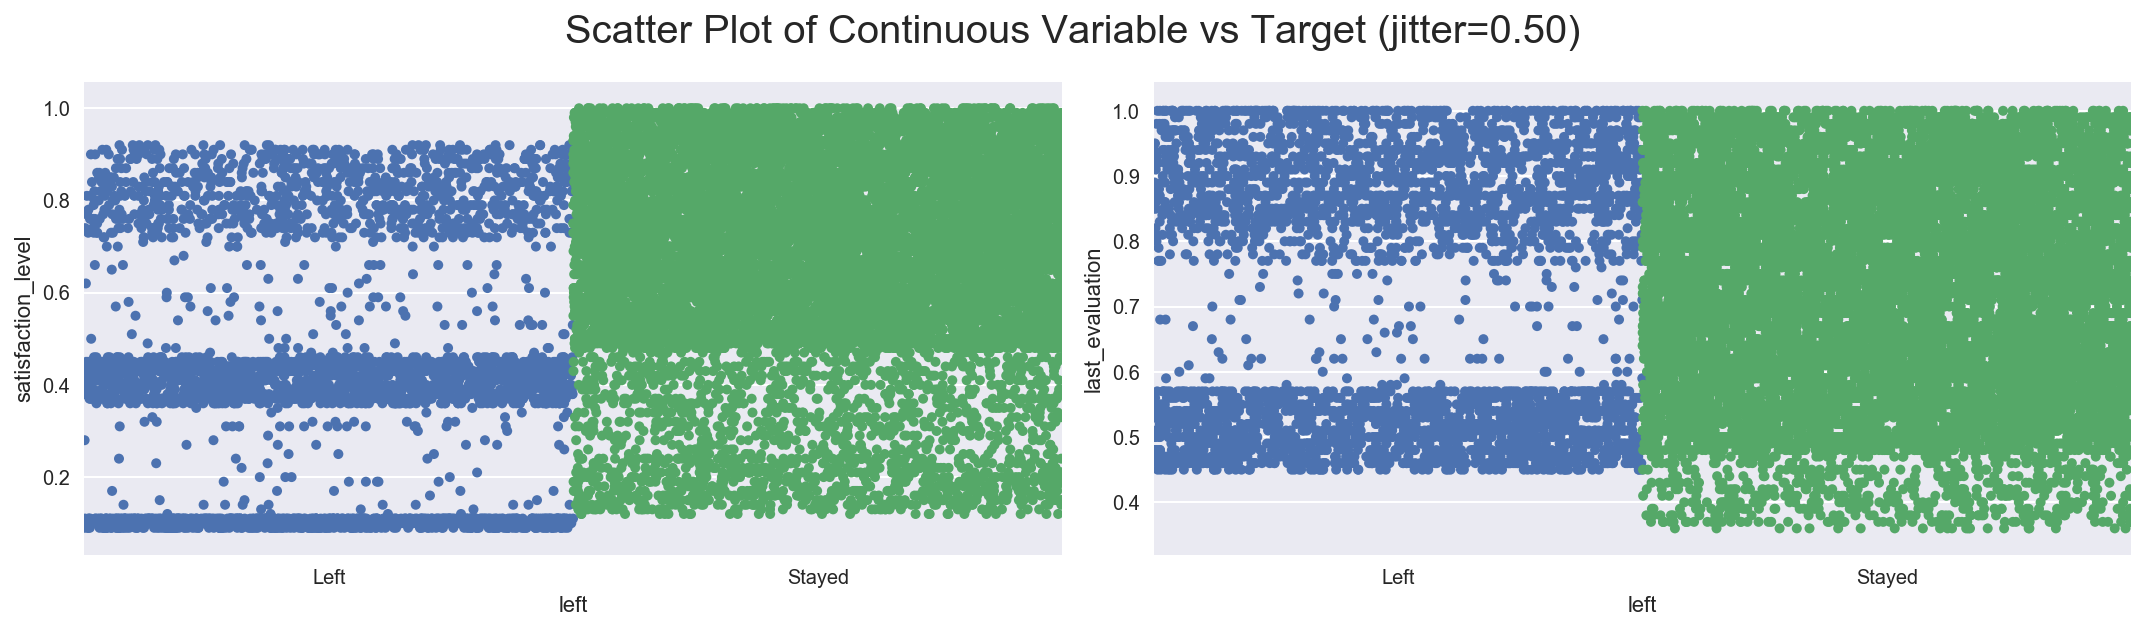

Total Number of Scatter Plots = 3


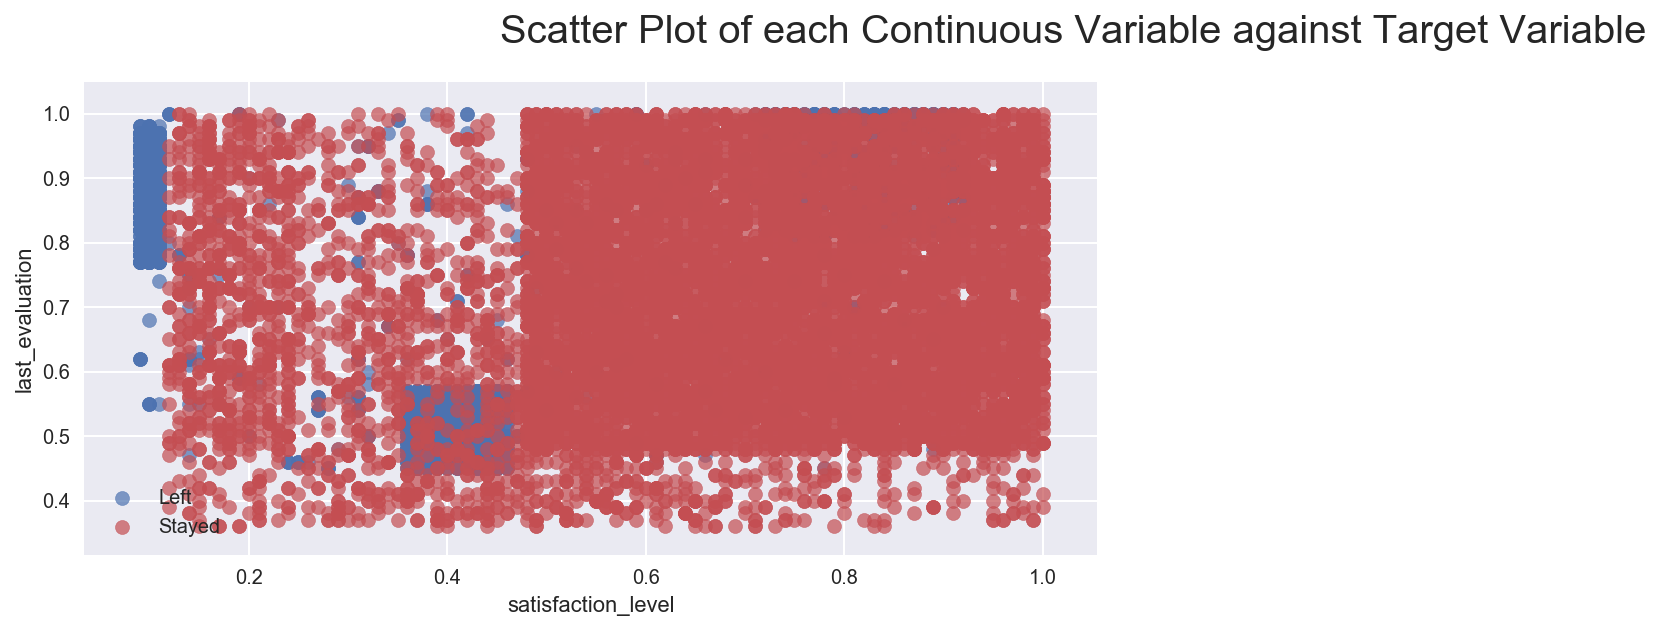

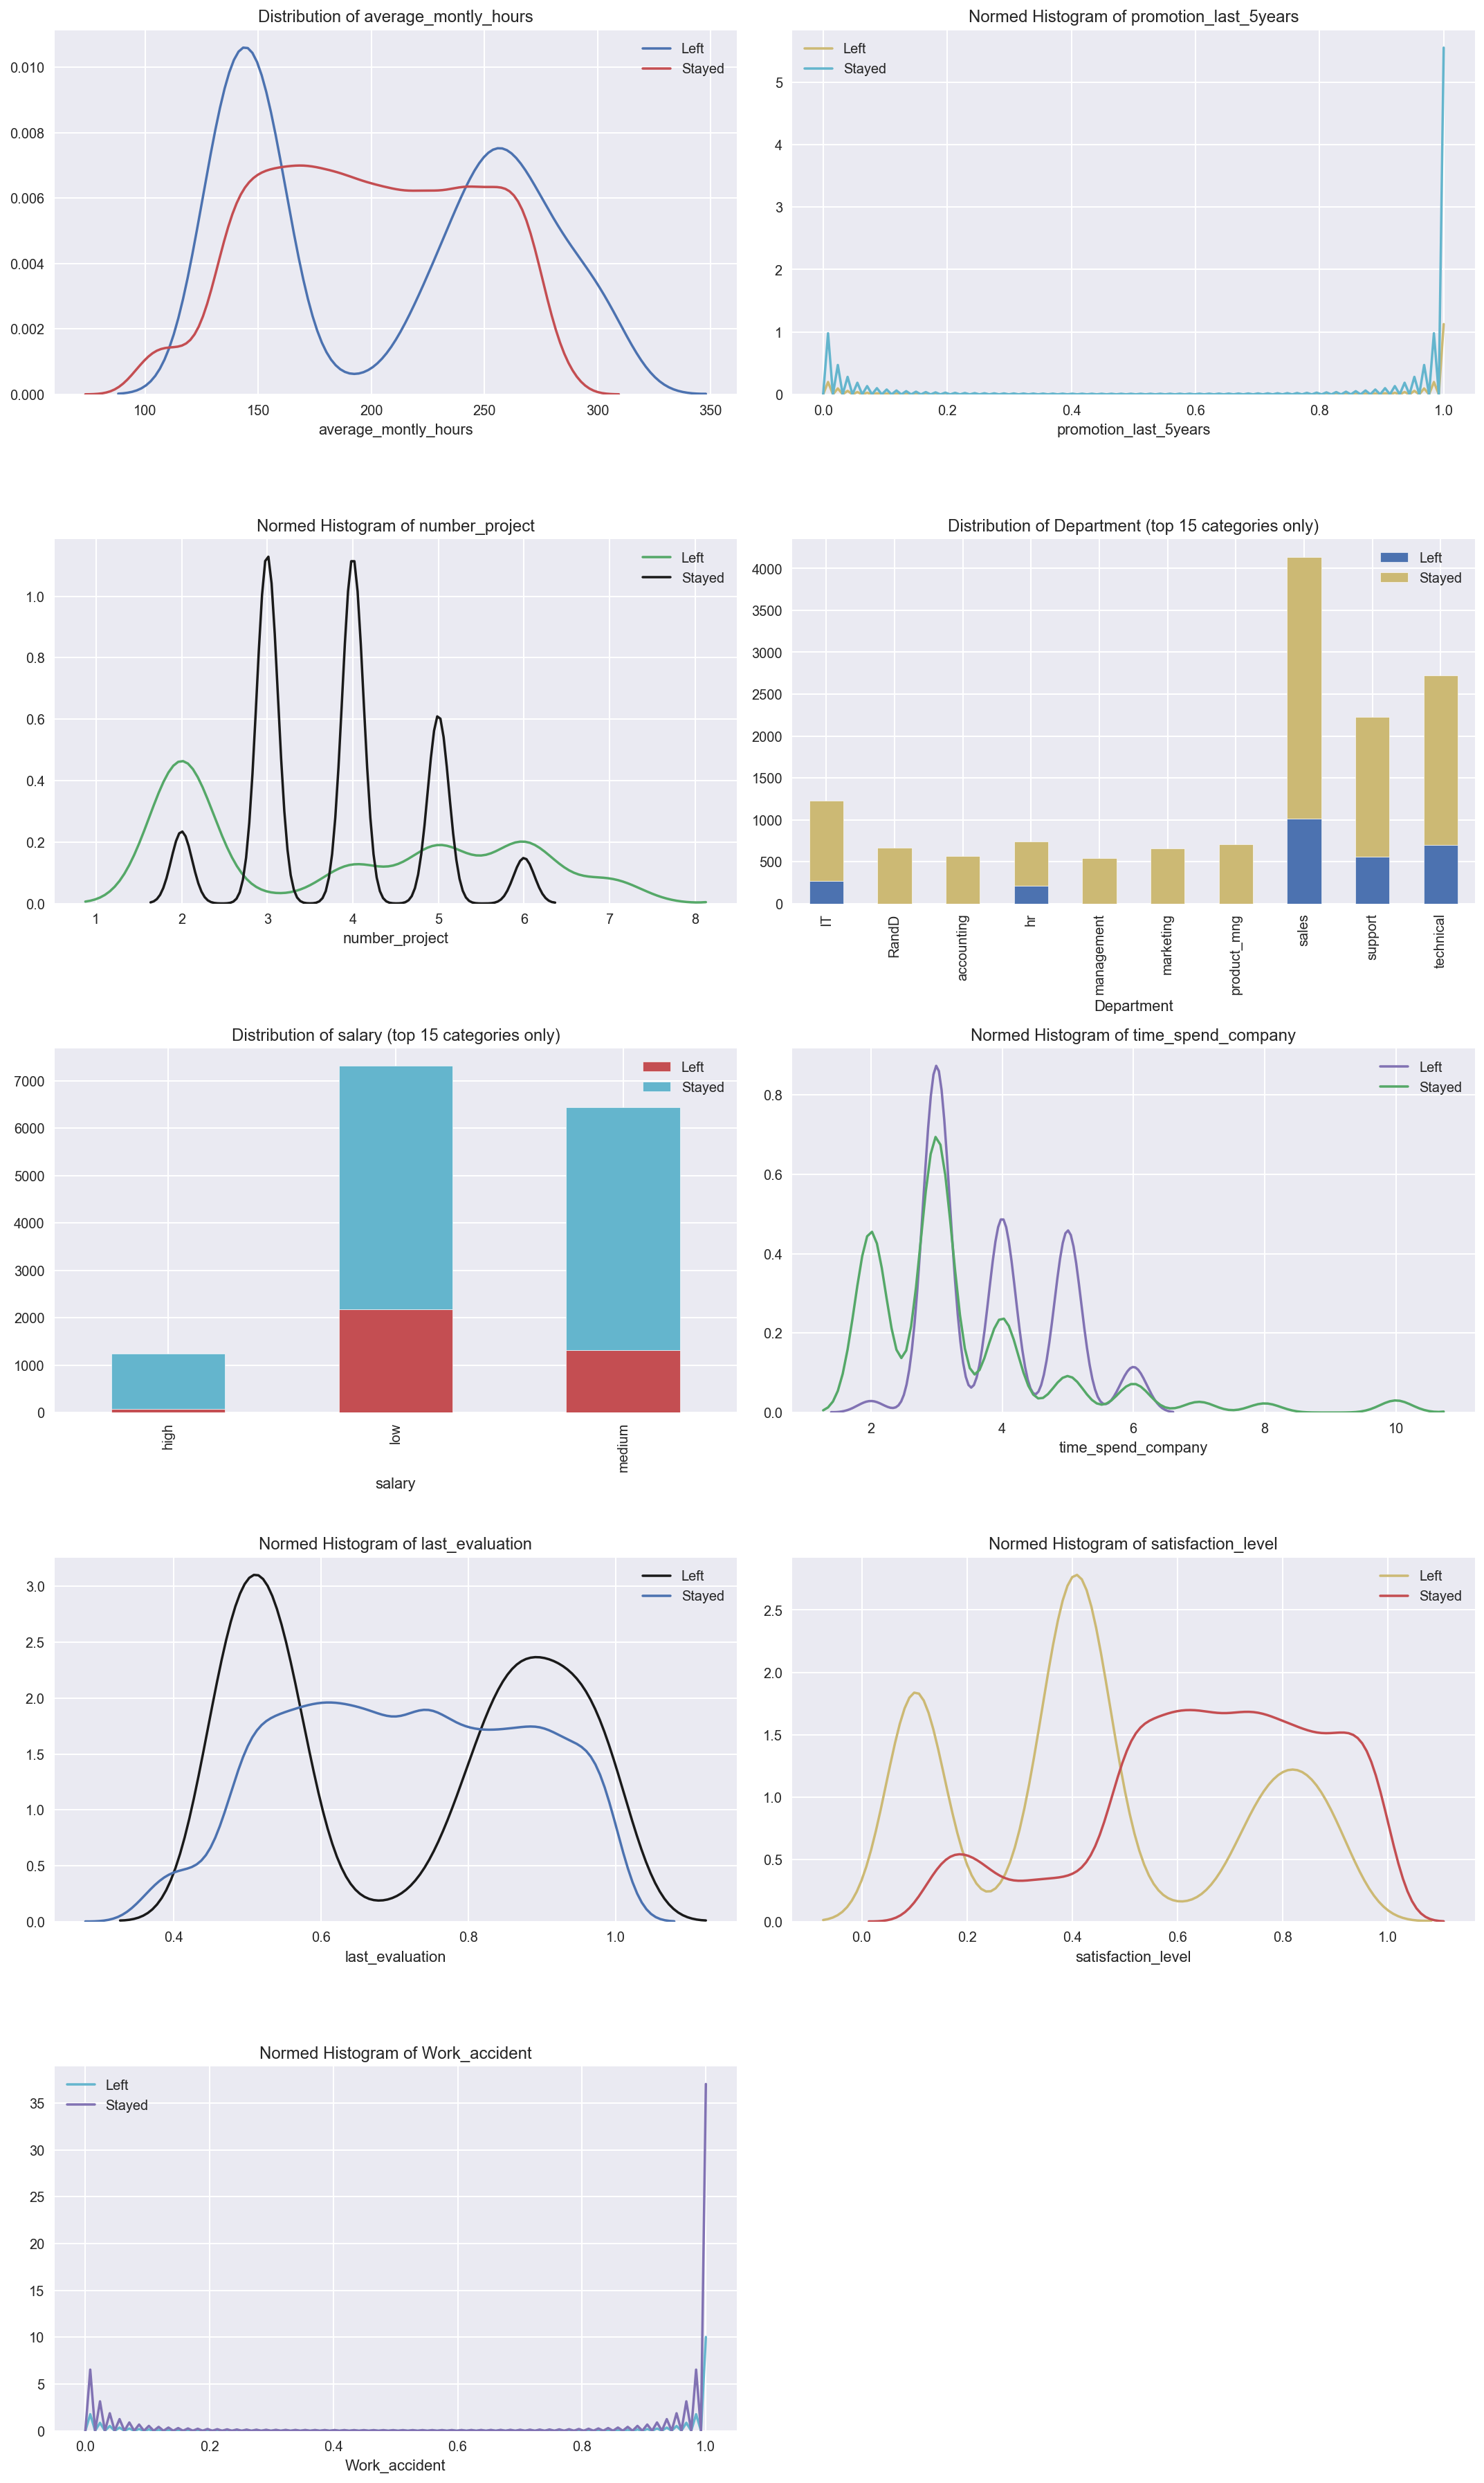

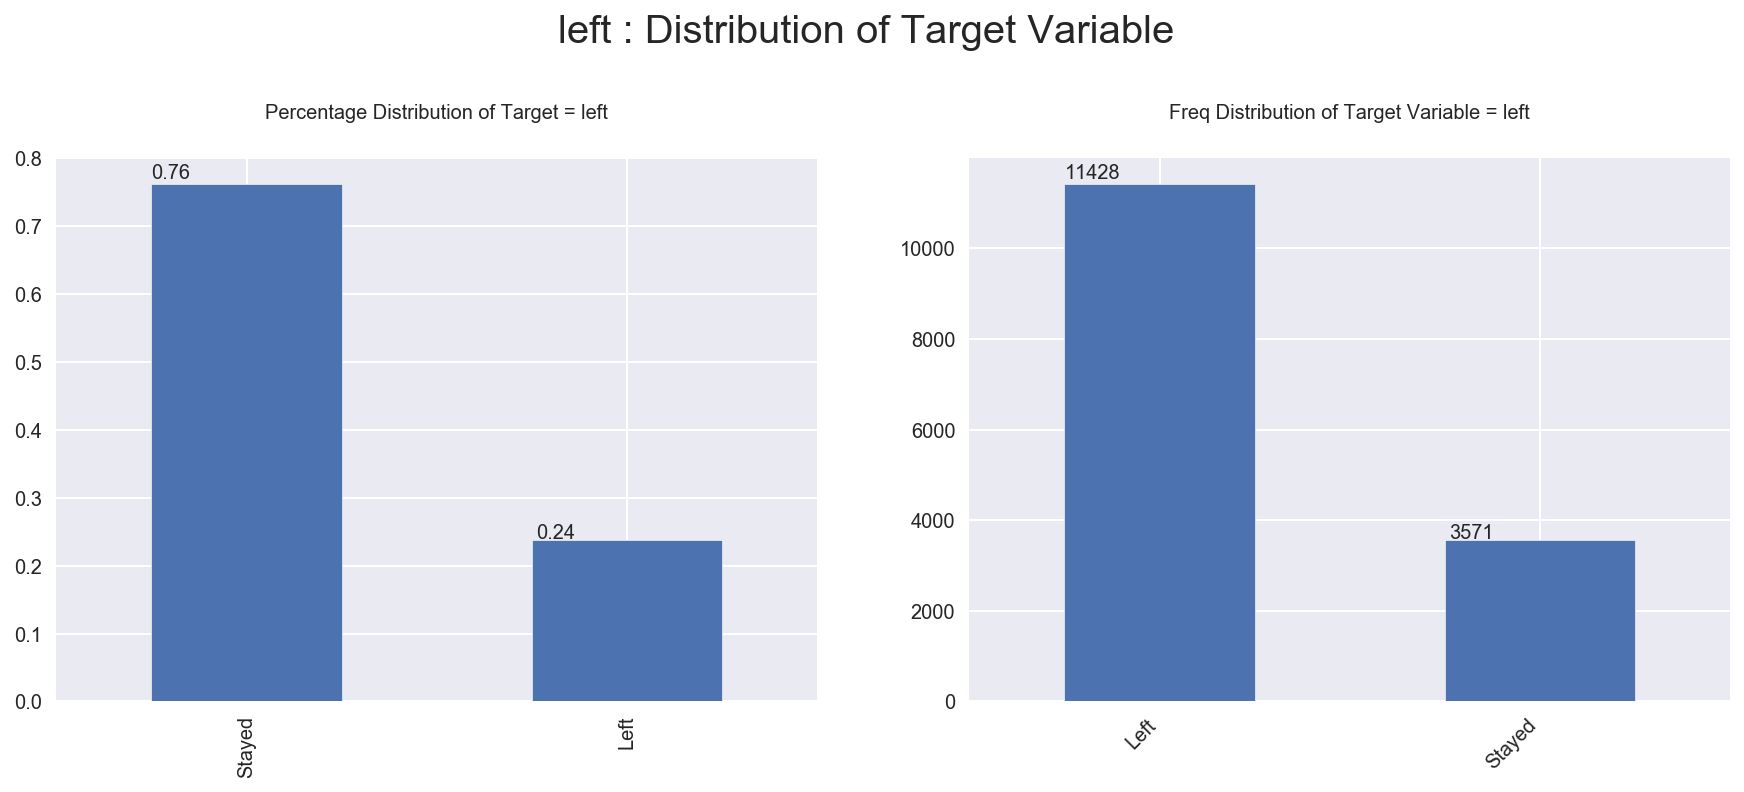

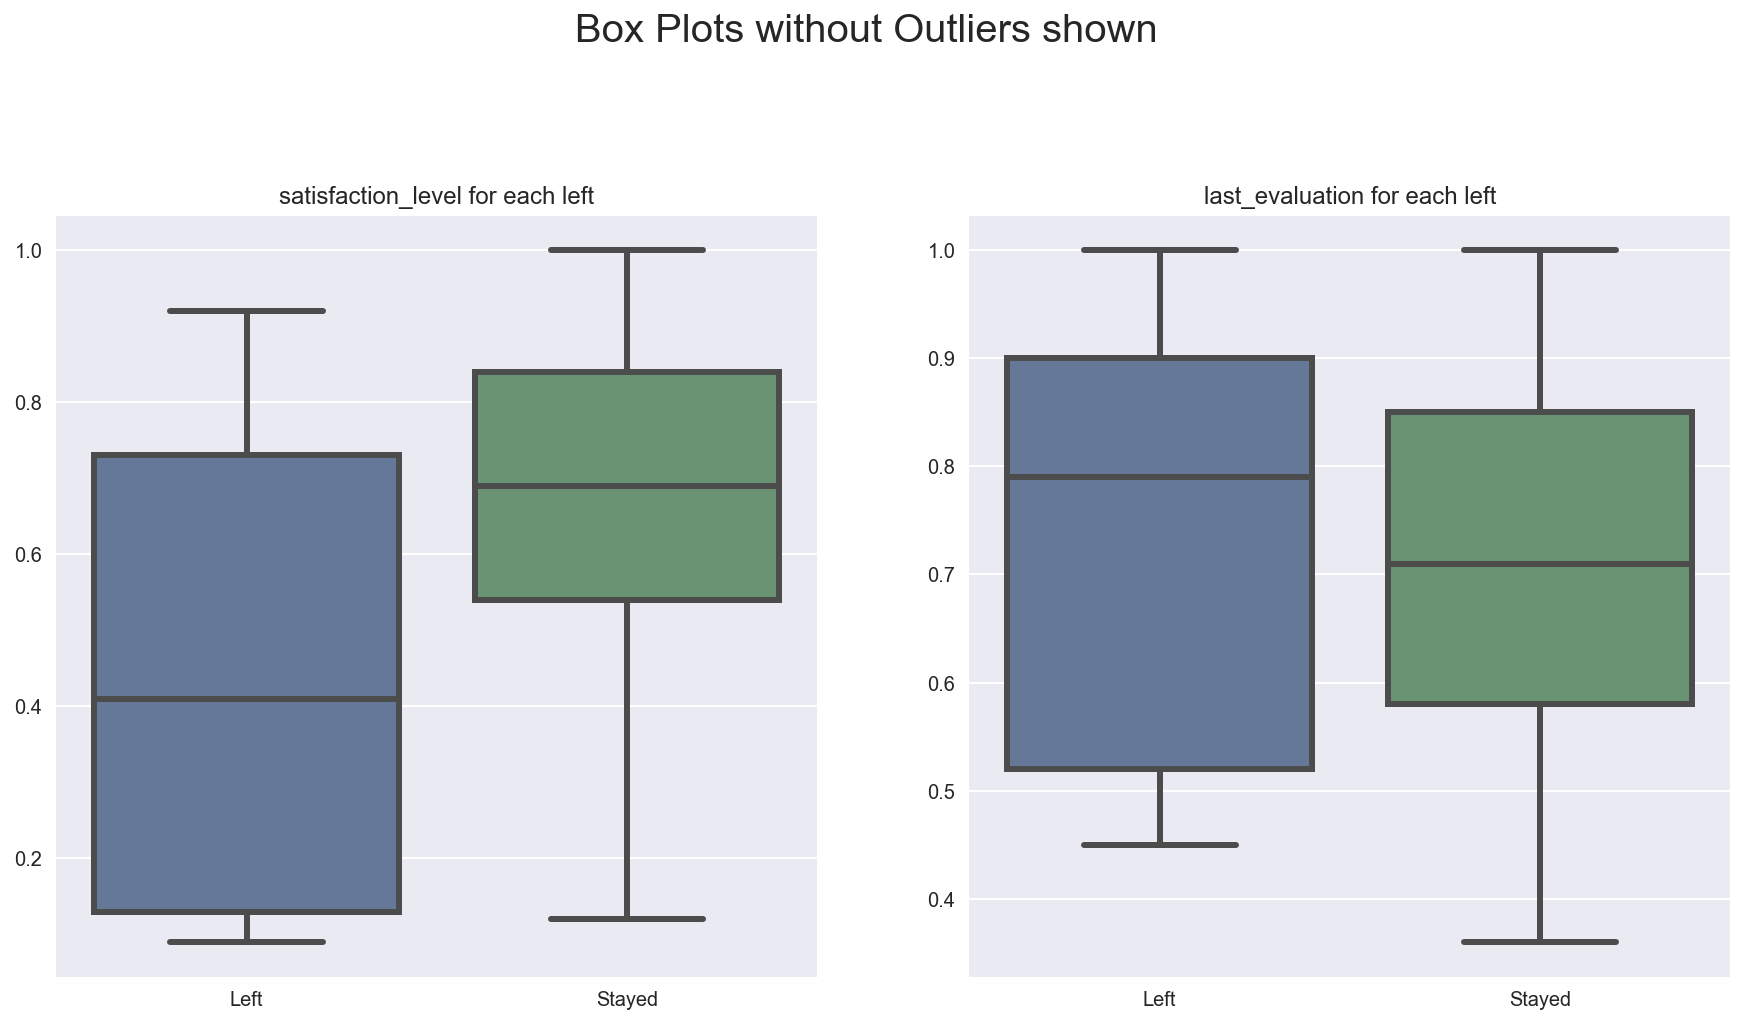

No date vars could be found in data set


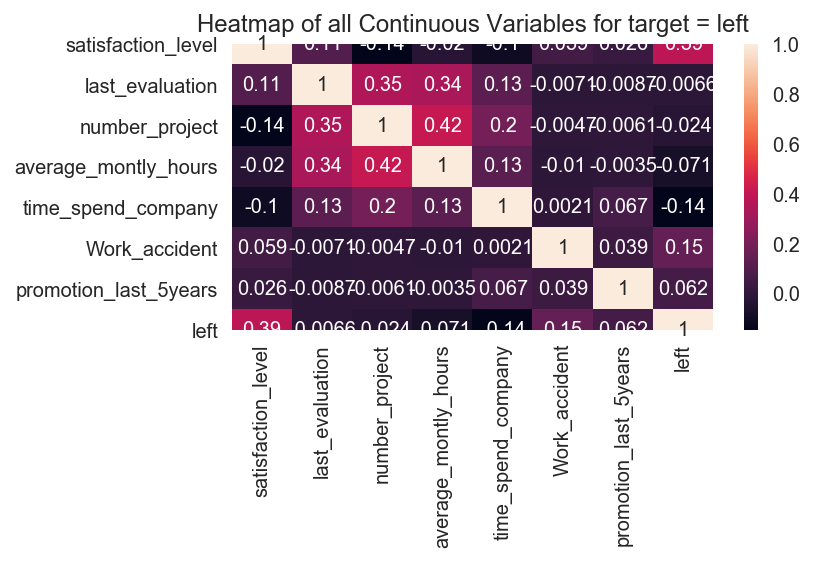

No. of Bar Plots = 21.0


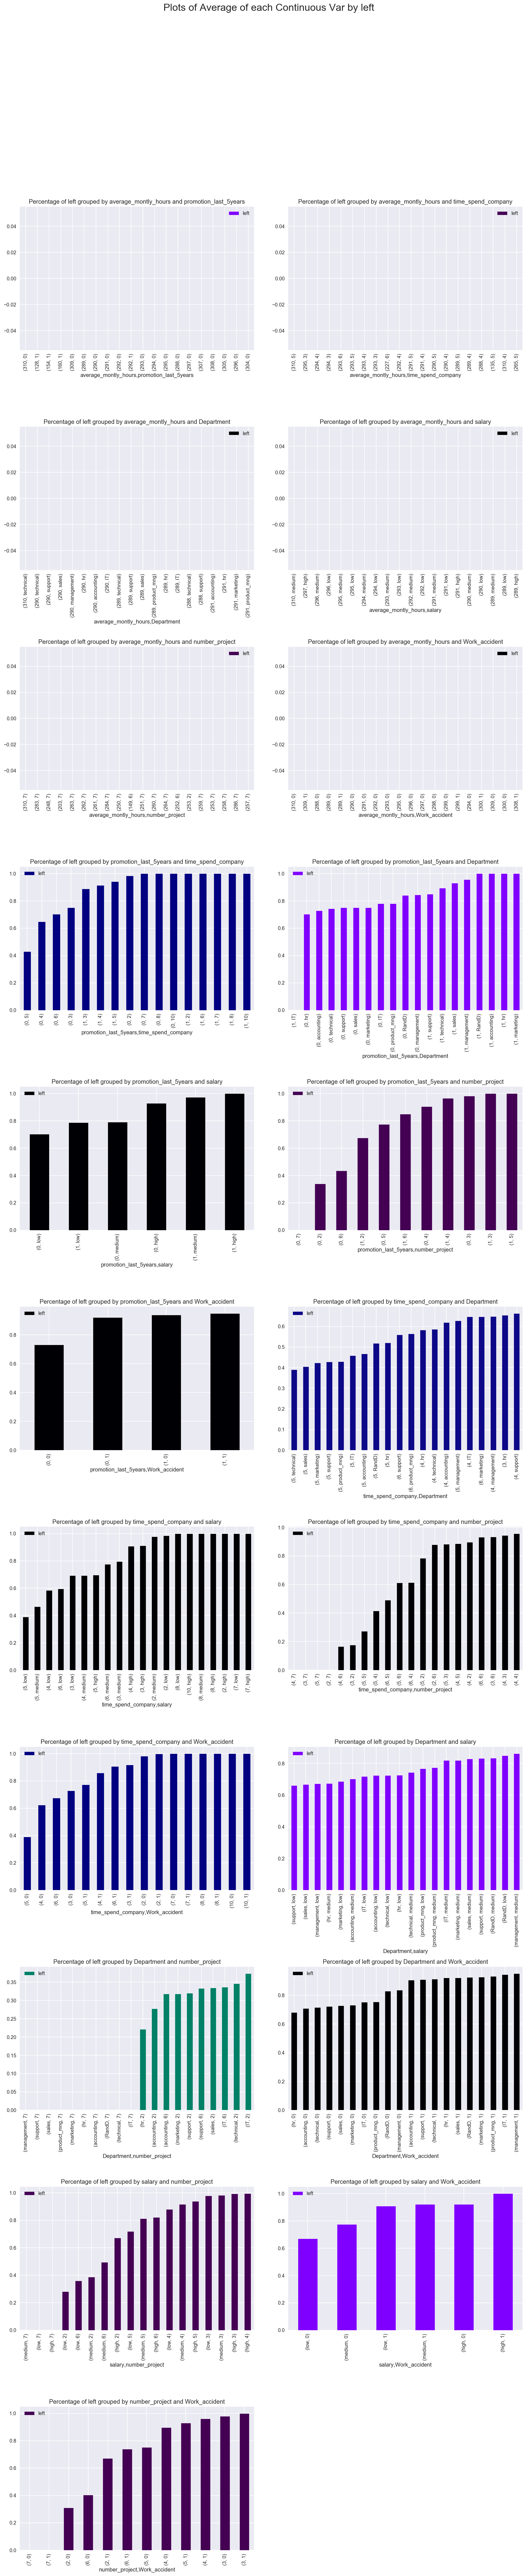

Nothing to add Plot not being added
All plots done
Time to run AutoViz (in seconds) = 25.587

 ###################### VISUALIZATION Completed ########################


In [9]:
AV = AutoViz_Class()
filename = ""
sep = ","
dft = AV.AutoViz(
    filename,
    sep,
    'left',
    raw_data,
    header=0,
    verbose=1,
    lowess=False,
    chart_format="svg",
    max_rows_analyzed=150000,
    max_cols_analyzed=30,
)

## Insights:

* Employees with number_project 3,4 make upto 50% of the data
* 14% of employees are involved in Work_accident
* Only 2% of ennployees are promoted in last 5 years
* Satisfaction Level for Employees who stayed is higher
* Work Related accident doesnt seem to have impact on Attrition
* employees with 2 projects tend to leave
* Promotion doesn't seem to impact on Attrition, but that can be attributed to the imbalance in the data
* Low salaried people tend to leave more, but again data is imbalanced, so cant conclude
* Employees who left didnt spend more than 7 hours in office
* Vast majority of the employees who left spent less than 4 hours in office
* Satisfaction Level seems to have a mid point cut off where if its less than .5 people tend to leave and vice versa

In [10]:
# Modify data in the Target column as before
raw_data['left']=raw_data['left'].map({'Stayed':0,'Left':1})

In [11]:
#Get the Department wise employee count
raw_data['Department'].value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: Department, dtype: int64

In [12]:
#Get the Salary distribution counts
raw_data['salary'].value_counts()

low       7316
medium    6446
high      1237
Name: salary, dtype: int64

In [13]:
# For one hot encoding use get_dummies
raw_data=pd.get_dummies(raw_data)

In [14]:
# Check if Feature SPace is increased
raw_data.shape

(14999, 21)

In [15]:
# divide X and y
X = raw_data.drop(labels='left', axis=1)
y = raw_data["left"]

In [16]:
#Standardise the features
X.nunique()

satisfaction_level         92
last_evaluation            65
number_project              6
average_montly_hours      215
time_spend_company          8
Work_accident               2
promotion_last_5years       2
Department_IT               2
Department_RandD            2
Department_accounting       2
Department_hr               2
Department_management       2
Department_marketing        2
Department_product_mng      2
Department_sales            2
Department_support          2
Department_technical        2
salary_high                 2
salary_low                  2
salary_medium               2
dtype: int64

In [17]:
for col in ['satisfaction_level',
    'last_evaluation',
    'number_project',
    'average_montly_hours',
    'time_spend_company'
  ]:
    X[col] -= X[col].min()
    X[col] /= X[col].max()

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2)

ANN with one layer and sigmoid activation is similar to logistic regression

In [19]:
from tensorflow.keras import Sequential
import tensorflow.keras as keras
import tensorflow as tf
model = Sequential()

In [20]:
tf.random.set_seed(100)
model.add(Dense(1, input_shape = (20, ), activation = 'sigmoid'))

model.compile('sgd', 'binary_crossentropy', metrics = ['accuracy'])

In [21]:
hist = model.fit(X_train,y_train,validation_data=(X_test,y_test))
# plot_loss_accuracy(hist)

Train on 11999 samples, validate on 3000 samples
11999/11999 [==============================] - 2s 131us/sample - loss: 0.5811 - accuracy: 0.7350 - val_loss: 0.5506 - val_accuracy: 0.7587


Accuracy of the logistic model is 76.31% which is bad as we know that the majority class is 76% 

In [23]:
tf.keras.backend.clear_session
tf.random.set_seed(100)
model = Sequential()
model.add(Dense(64,input_shape=(20,),activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
# model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(Adam(learning_rate=0.001), 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10)

Train on 11999 samples, validate on 3000 samples
Epoch 1/10
11999/11999 [==============================] - 2s 158us/sample - loss: 0.4144 - accuracy: 0.8136 - val_loss: 0.2741 - val_accuracy: 0.8807
Epoch 2/10
11999/11999 [==============================] - 1s 92us/sample - loss: 0.2271 - accuracy: 0.9142 - val_loss: 0.1855 - val_accuracy: 0.9407
Epoch 3/10
11999/11999 [==============================] - 1s 95us/sample - loss: 0.1737 - accuracy: 0.9432 - val_loss: 0.1698 - val_accuracy: 0.9470
Epoch 4/10
11999/11999 [==============================] - 1s 95us/sample - loss: 0.1586 - accuracy: 0.9497 - val_loss: 0.1585 - val_accuracy: 0.9530
Epoch 5/10
11999/11999 [==============================] - 4s 357us/sample - loss: 0.1514 - accuracy: 0.9512 - val_loss: 0.1552 - val_accuracy: 0.9513
Epoch 6/10
11999/11999 [==============================] - 4s 357us/sample - loss: 0.1455 - accuracy: 0.9547 - val_loss: 0.1514 - val_accuracy: 0.9553
Epoch 7/10
11999/11999 [==============================

In [26]:
# Plot Loss in Train vs Test data
historydf = pd.DataFrame(hist.history, index=hist.epoch)
import plotly.graph_objs as go#visualization
train_loss = {
  "mode": "lines+markers", 
  "name": "Train Epoch Loss", 
  "type": "scatter", 
  "x":hist.epoch, 
  "y":  hist.history['loss']
}
test_loss = {
  "mode": "lines+markers", 
  "name": "Test Epoch Loss", 
  "type": "scatter", 
  "x":hist.epoch, 
  "y":  hist.history['val_loss']
}

data = [train_loss,test_loss]
layout = {
  "title": "Training vs Testing Data Loss per Epoch", 
  "xaxis": {"title": "Epoch"}, 
  "yaxis": {"title": "Loss"}
}
fig = go.Figure(data=data, layout=layout)
fig.show()

In [25]:
# Plot Validation Accuracy vs Train Accuracy
train_acc = {
  "mode": "lines+markers", 
  "name": "Train Accuracy", 
  "type": "scatter", 
  "x":hist.epoch, 
  "y":   hist.history['accuracy']
}
test_acc = {
  "mode": "lines+markers", 
  "name": "Test Accuracy", 
  "type": "scatter", 
  "x":hist.epoch, 
  "y":  hist.history['val_accuracy']
}

data = [train_acc,test_acc]
layout = {
  "title": "Training vs Testing Data Accuracy per Epoch", 
  "xaxis": {"title": "Epoch"}, 
  "yaxis": {"title": "Loss"}
}
fig = go.Figure(data=data, layout=layout)
fig.show()

From the above graphs its clear that epochs=3 works well with above setting as we see that the validation loss increases and the accuracy of validation decreasing

Its clear from the above that a basic ANN model without any hyper param tuning gave us 95% accuracy and this is clear case of improvment against Logistic Regression.

Hence this proves that ANN models perform much better than regular machine learning algorithms